In [13]:
from google.colab import drive
drive.mount('/content/drive')  # colab과 google drive 연결


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd
import os
import string  # 특수문자 등을 처리하는 텍스트 처리용 도구

# 드라이브에서 뉴스 기사 데이터 읽어오기
df = pd.read_csv("/content/ArticlesFeb2017.csv")
print(df.columns)


Index(['articleID', 'abstract', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL',
       'articleWordCount'],
      dtype='object')


In [17]:
import numpy as np
import glob
import pandas as pd
import string

from torch.utils.data.dataset import Dataset

class TextGeneration(Dataset):
    def clean_text(self, txt):
        # 모든 단어를 소문자로 바꾸고 특수문자를 제거
        txt = "".join(v for v in txt if v not in string.punctuation).lower()
        return txt

    def __init__(self):
        self.all_headlines = []

        # Colab 로컬 디렉토리에서 "Articles" 이름이 포함된 CSV 파일만 선택
        for filename in glob.glob("/content/*.csv"):
            if 'Articles' in filename:
                article_df = pd.read_csv(filename)

                # headline 컬럼이 존재할 때만 처리
                if 'headline' in article_df.columns:
                    self.all_headlines.extend(list(article_df['headline'].values))
                    break  # 여러 파일 중 첫 번째만 사용

        # "Unknown" 값 제거
        self.all_headlines = [h for h in self.all_headlines if h != "Unknown"]

        # 전처리된 문장 리스트 생성
        self.corpus = [self.clean_text(x) for x in self.all_headlines]

        # 단어별 고유 인덱스를 지정할 Bag of Words (BOW) 사전 생성
        self.BOW = {}
        for line in self.corpus:
            for word in line.split():
                if word not in self.BOW:
                    self.BOW[word] = len(self.BOW)

        # 학습용 입력-출력 시퀀스 생성
        self.data = self.generate_sequence(self.corpus)

    def generate_sequence(self, txt):
        seq = []
        for line in txt:
            line = line.split()
            if len(line) < 3:
                continue  # 최소 3단어 이상인 문장만 사용
            line_bow = [self.BOW[word] for word in line]

            # 단어 2개 → 다음 단어 예측 (3-gram)
            data = [([line_bow[i], line_bow[i+1]], line_bow[i+2])
                    for i in range(len(line_bow) - 2)]
            seq.extend(data)
        return seq

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        x = np.array(self.data[i][0])  # 입력 시퀀스 (2단어)
        y = np.array(self.data[i][1]).astype(np.float32)  # 출력 단어 (정답)
        return x, y


In [18]:
import torch
import torch.nn as nn

# pytorch의 nn.Module을 상속받아 새로운 LSTM 기반 텍스트 생성 모델 정의
class LSTM(nn.Module):
    def __init__(self, num_embeddings):
        super(LSTM, self).__init__()

        # 희소 표현을 밀집 표현으로 만들기 위한 임베딩층
        self.embed = nn.Embedding(
            num_embeddings=num_embeddings,
            embedding_dim=16
        )

        self.lstm = nn.LSTM(
            input_size=16,
            hidden_size=64,
            num_layers=5,
            batch_first=True  # LSTM은 계층이 여러 개일 때, 맨 마지막 층의 출력만 반환됨
        )

        # 분류를 위한 MLP층
        self.fc1 = nn.Linear(128, num_embeddings)
        self.fc2 = nn.Linear(num_embeddings, num_embeddings)  # 최종 출력

        # 활성화 함수
        self.relu = nn.ReLU()

    # LSTM에 들어가는 입력은 [batch_size, seq_len, input_size] 형태
    # - batch_size: 한 번에 처리하는 문장 수
    # - seq_len: 각 문장의 단어 개수
    # - input_size: 임베딩 벡터 차원 (여기선 16차원)

    def forward(self, x):
        x = self.embed(x)  # [batch, seq_len] → [batch, seq_len, 16]

        # LSTM 통과 → hidden state 출력
        x, _ = self.lstm(x)  # 출력: [batch, seq_len, 64]

        # 모든 시퀀스의 hidden state를 이어붙이기 (Flatten)
        x = torch.reshape(x, (x.shape[0], -1))  # [batch, seq_len × 64] 예: [batch, 128]

        # MLP 통과 (예측값 생성)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x


In [19]:
import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

# 학습을 진행할 프로세서 정의
device = "cuda" if torch.cuda.is_available() else "cpu"

# 커스텀 데이터셋 불러오기
dataset = TextGeneration()

# 모델 정의
model = LSTM(num_embeddings=len(dataset.BOW)).to(device)

# 배치 단위로 데이터 나눔
loader = DataLoader(dataset, batch_size=64)

# 옵티마이저 정의
optim = Adam(model.parameters(), lr=0.001)

# 학습 루프
for epoch in range(200):
    iterator = tqdm.tqdm(loader)
    for data, label in iterator:
        # 기울기 초기화
        optim.zero_grad()

        # 모델의 예측값
        pred = model(torch.tensor(data, dtype=torch.long).to(device))

        # 정답 레이블은 long 텐서로 변환
        loss = nn.CrossEntropyLoss()(
            pred, torch.tensor(label, dtype=torch.long).to(device)
        )

        # 오차 역전파
        loss.backward()
        optim.step()

        # 현재 손실을 tqdm에 표시
        iterator.set_description(f"epoch{epoch} loss:{loss.item()}")

# 모델 저장
torch.save(model.state_dict(), "lstm.pth")

def generate(model, BOW, string="finding an ", strlen=10):  # finding an 이후의 10개 단어를 생성하겠다
    device = "cuda" if torch.cuda.is_available() else "cpu"

    print(f"input word: {string}")

    with torch.no_grad():  # 빠른 계산을 위해 기울기 계산 비활성화
        for p in range(strlen):  # 한 단어씩 예측해 문장을 점점 늘림
            # 입력 문장을 텐서로 변경 (현재까지의 문장을 BOW 인덱스로 변환)
            words = torch.tensor(
                [BOW[w] for w in string.split()],
                dtype=torch.long
            ).to(device)

            # LSTM의 입력을 만듦 (마지막 두 단어만 사용)
            input_tensor = torch.unsqueeze(words[-2:], dim=0)

            # 모델을 이용해 예측
            output = model(input_tensor)

            # 가장 확률이 높은 단어 인덱스 선택 (argmax)
            output_word = torch.argmax(output).cpu().numpy()

            # 예측된 단어를 다시 문자열에 추가
            string += list(BOW.keys())[output_word]
            string += " "

    print(f"predicted sentence: {string}")


  0%|          | 0/59 [00:00<?, ?it/s]<ipython-input-19-617d913b2857>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(data, dtype=torch.long).to(device))
<ipython-input-19-617d913b2857>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred, torch.tensor(label, dtype=torch.long).to(device)
epoch199 loss:0.3260146677494049: 100%|██████████| 59/59 [00:19<00:00,  3.00it/s]


In [36]:
pred = generate(model, dataset.BOW, string="you are not ")


input word: you are not 
predicted sentence: you are not success on the va debate so into are obamacare to 



🧪 LSTM 1층 실험 중...
Epoch 1 - Loss: 6.9121
Epoch 2 - Loss: 6.8476
Epoch 3 - Loss: 6.7352
Epoch 4 - Loss: 6.5270
Epoch 5 - Loss: 6.2153
Epoch 6 - Loss: 5.8740
Epoch 7 - Loss: 5.5706
Epoch 8 - Loss: 5.3066
Epoch 9 - Loss: 5.0468
Epoch 10 - Loss: 4.8178

🧪 LSTM 2층 실험 중...
Epoch 1 - Loss: 6.9103
Epoch 2 - Loss: 6.8706
Epoch 3 - Loss: 6.7741
Epoch 4 - Loss: 6.5570
Epoch 5 - Loss: 6.2736
Epoch 6 - Loss: 6.0015
Epoch 7 - Loss: 5.7576
Epoch 8 - Loss: 5.5391
Epoch 9 - Loss: 5.3287
Epoch 10 - Loss: 5.1342

🧪 LSTM 5층 실험 중...
Epoch 1 - Loss: 6.9094
Epoch 2 - Loss: 6.8824
Epoch 3 - Loss: 6.8505
Epoch 4 - Loss: 6.8368
Epoch 5 - Loss: 6.8299
Epoch 6 - Loss: 6.8237
Epoch 7 - Loss: 6.8111
Epoch 8 - Loss: 6.7694
Epoch 9 - Loss: 6.7304
Epoch 10 - Loss: 6.7001


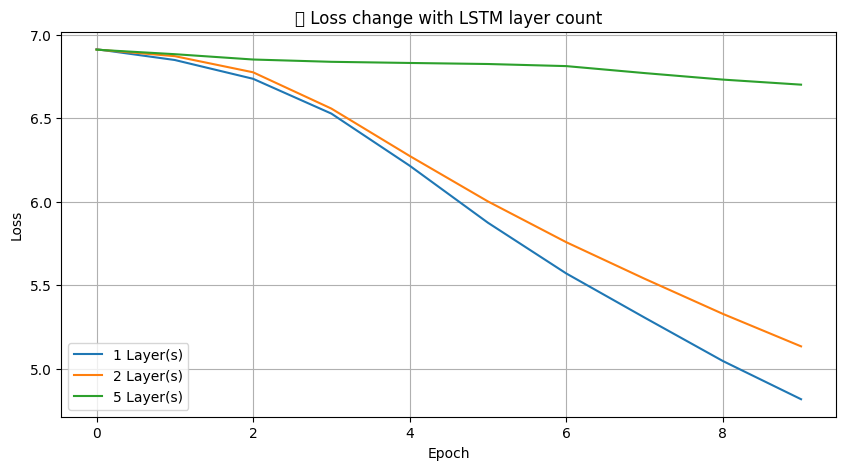

In [38]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------------------
# 1. 샘플 데이터셋 클래스
# ------------------------------
class DummyTextDataset(Dataset):
    def __init__(self, vocab_size=1000, length=5000):
        self.x = np.random.randint(0, vocab_size, (length, 2))
        self.y = np.random.randint(0, vocab_size, (length,))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.float32)

# ------------------------------
# 2. LSTM 기반 예측 모델
# ------------------------------
class LSTM(nn.Module):
    def __init__(self, num_embeddings=1000, num_layers=1):
        super().__init__()
        self.embed = nn.Embedding(num_embeddings, 16)
        self.lstm = nn.LSTM(input_size=16, hidden_size=64, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(64 * 2, num_embeddings)  # 2단어 입력 → 출력층
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x, y=None):
        x = self.embed(x)  # [batch, 2, 16]
        out, _ = self.lstm(x)  # [batch, 2, 64]
        out = out.reshape(out.size(0), -1)  # Flatten: [batch, 128]
        logits = self.fc(out)  # [batch, vocab_size]
        if y is not None:
            loss = self.loss_fn(logits, y.long())
            return loss
        return logits

# ------------------------------
# 3. 학습 함수
# ------------------------------
def train_model(model, loader, optimizer, device, epochs=10):
    model.to(device)
    loss_history = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = model(x, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")
    return loss_history

# ------------------------------
# 4. 실험 실행
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = DummyTextDataset()
loader = DataLoader(dataset, batch_size=64, shuffle=True)

loss_histories = {}

for num_layers in [1, 2, 5]:
    print(f"\n🧪 LSTM {num_layers}층 실험 중...")
    model = LSTM(num_embeddings=1000, num_layers=num_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_histories[num_layers] = train_model(model, loader, optimizer, device)

# ------------------------------
# 5. 시각화
# ------------------------------
plt.figure(figsize=(10, 5))
for num_layers, losses in loss_histories.items():
    plt.plot(losses, label=f"{num_layers} Layer(s)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("📉 Loss change with LSTM layer count")
plt.legend()
plt.grid()
plt.show()
